Epoch 1/200


c:\Users\jerry\miniconda3\envs\torch-gpu\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 9.4607e-04 - val_loss: 5.0650e-05
Epoch 2/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 8.7847e-04 - val_loss: 9.3973e-05
Epoch 3/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 7.8831e-04 - val_loss: 5.1833e-05
Epoch 4/200
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 9.7910e-04 - val_loss: 7.6121e-05
RMSE: 6.612644329755505e-07


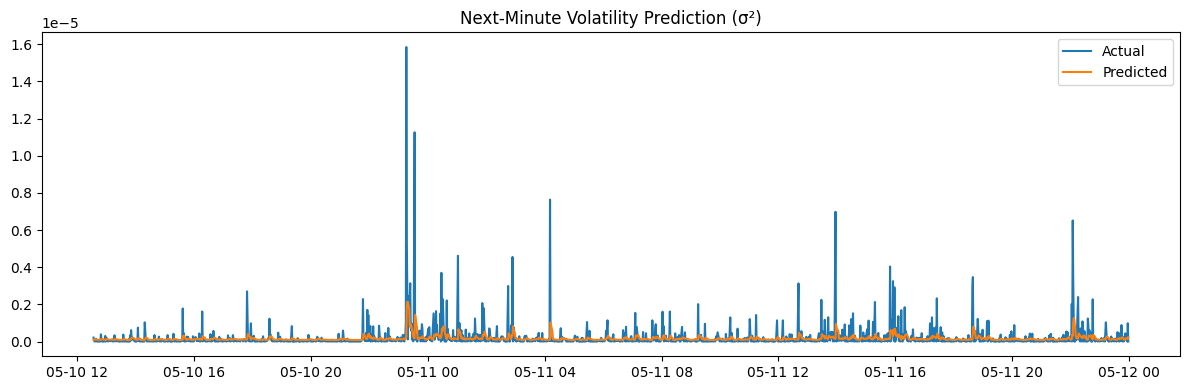

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

df = pd.read_parquet("btc_data.parquet")

returns = np.log(df["Close"]).diff().dropna()
target_series = returns.pow(2)               

scaler = MinMaxScaler()
scaled = scaler.fit_transform(target_series.values.reshape(-1, 1)).flatten()

def make_windows(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i : i + lookback])
        y.append(series[i + lookback])
    return np.array(X)[..., None], np.array(y)

lookback = 5                             
X, y = make_windows(scaled, lookback)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential([
    LSTM(64, input_shape=(lookback, 1)),
    Dense(32, activation="relu"),
    Dense(1)
])
model.compile(optimizer="adam", loss="mse")
model.fit(
    X_train, y_train,
    epochs=200,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

pred_scaled = model.predict(X_test, verbose=0).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(actual, pred))
print("RMSE:", rmse)

plt.figure(figsize=(12, 4))
plt.plot(target_series.index[-len(actual):], actual, label="Actual")
plt.plot(target_series.index[-len(pred):], pred, label="Predicted")
plt.title("Next-Minute Volatility Prediction (σ²)")
plt.legend()
plt.tight_layout()
plt.show()


Model: "functional_47"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_45 (InputLayer)     │ (None, 3, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_103 (Dense)               │ (None, 3, 64)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_11         │ (None, 3, 64)          │           192 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_28            │ (None, 3, 64)          │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_29            │ (None, 3, 64)          │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_13     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_103 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_108 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_109 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,377 (271.00 KB)

 Trainable params: 69,377 (271.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 67ms/step - loss: 0.1876 - val_loss: 0.0035
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0130 - val_loss: 6.4180e-04
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 68ms/step - loss: 0.0024 - val_loss: 5.1818e-05
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 79ms/step - loss: 0.0022 - val_loss: 5.6265e-05
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0016 - val_loss: 9.6524e-05
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 2s 77ms/step - loss: 0.0016 - val_loss: 7.2587e-05
RMSE: 6.876596640000906e-07


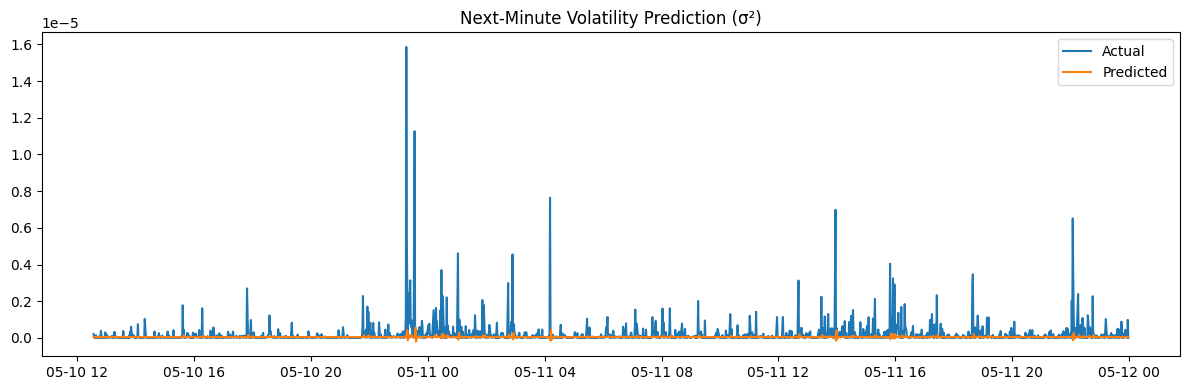

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LayerNormalization,
    MultiHeadAttention,
    Dropout,
    GlobalAveragePooling1D,
    Embedding,
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

@tf.keras.utils.register_keras_serializable()
def spiked_activation(x):
    return tf.nn.relu(x) * tf.exp(-0.5 * tf.square(tf.nn.relu(x) - 1.5))

class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.pos_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=d_model
        )

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_positions = self.pos_embedding_layer(positions)
        return inputs + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "sequence_length": self.sequence_length,
        })
        return config

class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, custom_activation_fn=spiked_activation, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.custom_activation_fn = custom_activation_fn

        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"
            )
        self.key_dim = embed_dim // num_heads

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=self.key_dim)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation=self.custom_activation_fn),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, inputs) 
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
            "custom_activation_fn": tf.keras.utils.serialize_keras_object(self.custom_activation_fn)
        })
        return config


def create_transformer_model(
    input_shape,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=1,
    dropout_rate=0.1,
    custom_activation_fn=spiked_activation
):
    lookback = input_shape[0]
    inputs = Input(shape=input_shape) 

    x = Dense(d_model, activation="relu")(inputs) 

    x = PositionalEmbedding(sequence_length=lookback, d_model=d_model)(x)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(
            embed_dim=d_model,
            num_heads=num_heads,
            ff_dim=ff_dim,
            rate=dropout_rate,
            custom_activation_fn=custom_activation_fn
        )(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x) 
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

df = pd.read_parquet("btc_data.parquet")

returns = np.log(df["Close"]).diff().dropna()
target_series = returns.pow(2)                

scaler = MinMaxScaler()
scaled = scaler.fit_transform(target_series.values.reshape(-1, 1)).flatten()

def make_windows(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i : i + lookback])
        y.append(series[i + lookback])
    return np.array(X)[..., None], np.array(y)

lookback = 3                                
X, y = make_windows(scaled, lookback)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

d_model = 64
num_heads = 8
ff_dim = d_model * 2 
num_transformer_blocks = 2 
dropout_rate = 0.1

model = create_transformer_model(
    input_shape=(lookback, 1),
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout_rate=dropout_rate,
    custom_activation_fn=spiked_activation
)

model.compile(optimizer="adam", loss="mse")
model.summary()

model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1 

pred_scaled = model.predict(X_test, verbose=0).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(actual, pred))
print("RMSE:", rmse)

plt.figure(figsize=(12, 4))
plt.plot(target_series.index[-len(actual):], actual, label="Actual")
plt.plot(target_series.index[-len(pred):], pred, label="Predicted")
plt.title("Next-Minute Volatility Prediction (σ²)")
plt.legend()
plt.tight_layout()
plt.show()

Model: "functional_53"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_51 (InputLayer)     │ (None, 5, 1)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_117 (Dense)               │ (None, 5, 64)          │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ positional_embedding_13         │ (None, 5, 64)          │           320 │
│ (PositionalEmbedding)           │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_32            │ (None, 5, 64)          │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_block_33            │ (None, 5, 64)          │        33,472 │
│ (TransformerBlock)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_15     │ (None, 64)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_117 (Dropout)           │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_122 (Dense)               │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_123 (Dense)               │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 69,505 (271.50 KB)

 Trainable params: 69,505 (271.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 5s 55ms/step - loss: 0.3892 - val_loss: 2.9327e-04
Epoch 2/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0150 - val_loss: 8.6999e-04
Epoch 3/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0108 - val_loss: 7.4836e-04
Epoch 4/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0080 - val_loss: 1.1615e-04
Epoch 5/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0058 - val_loss: 1.6301e-04
Epoch 6/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0043 - val_loss: 5.0102e-05
Epoch 7/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0034 - val_loss: 1.3999e-04
Epoch 8/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0030 - val_loss: 2.2995e-04
Epoch 9/25
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step - loss: 0.0026 - val_loss: 5.1081e-05
RMSE: 6.739886256594951e-07


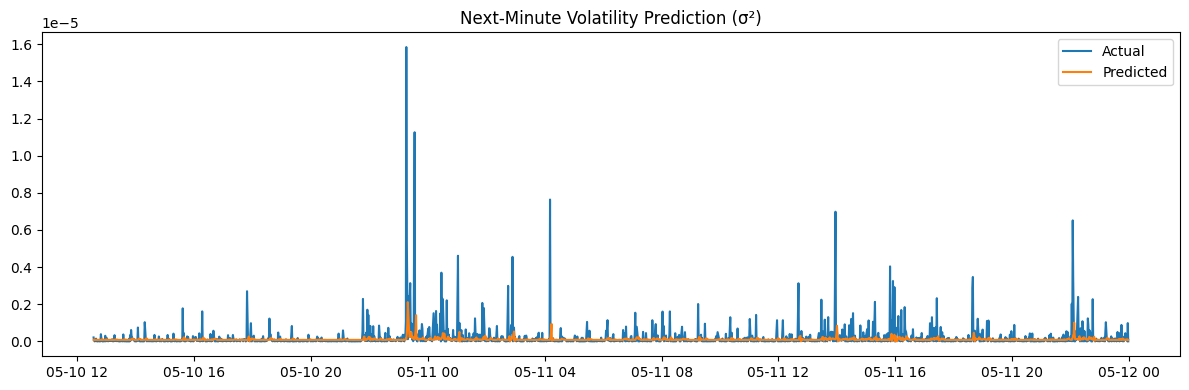

In [99]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Dense,
    LayerNormalization,
    MultiHeadAttention,
    Dropout,
    GlobalAveragePooling1D,
    Embedding,
)
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# Positional Embedding Layer
class PositionalEmbedding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model, **kwargs):
        super().__init__(**kwargs)
        self.d_model = d_model
        self.sequence_length = sequence_length
        self.pos_embedding_layer = Embedding(
            input_dim=sequence_length, output_dim=d_model
        )

    def call(self, inputs):
        positions = tf.range(start=0, limit=self.sequence_length, delta=1)
        embedded_positions = self.pos_embedding_layer(positions)
        return inputs + embedded_positions

    def get_config(self):
        config = super().get_config()
        config.update({
            "d_model": self.d_model,
            "sequence_length": self.sequence_length,
        })
        return config

# Transformer Encoder Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1, activation_fn="relu", **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.ff_dim = ff_dim
        self.rate = rate
        self.activation_fn = activation_fn

        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embed_dim ({embed_dim}) must be divisible by num_heads ({num_heads})"
            )
        self.key_dim = embed_dim // num_heads

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=self.key_dim)
        self.ffn = tf.keras.Sequential(
            [
                Dense(ff_dim, activation=self.activation_fn),
                Dense(embed_dim),
            ]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=False):
        attn_output = self.att(inputs, inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "ff_dim": self.ff_dim,
            "rate": self.rate,
            "activation_fn": tf.keras.utils.serialize_keras_object(self.activation_fn)
        })
        return config

# Function to create the Transformer model
def create_transformer_model(
    input_shape,
    d_model=64,
    num_heads=4,
    ff_dim=128,
    num_transformer_blocks=1,
    dropout_rate=0.1,
    activation_fn="relu"
):
    lookback = input_shape[0]
    inputs = Input(shape=input_shape)

    x = Dense(d_model, activation="relu")(inputs)

    x = PositionalEmbedding(sequence_length=lookback, d_model=d_model)(x)

    for _ in range(num_transformer_blocks):
        x = TransformerBlock(
            embed_dim=d_model,
            num_heads=num_heads,
            ff_dim=ff_dim,
            rate=dropout_rate,
            activation_fn=activation_fn
        )(x)

    x = GlobalAveragePooling1D()(x)
    x = Dropout(dropout_rate)(x)
    x = Dense(32, activation="relu")(x)
    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    return model

df = pd.read_parquet("btc_data.parquet")

returns = np.log(df["Close"]).diff().dropna()
target_series = returns.pow(2)                  # one-period conditional variance

scaler = MinMaxScaler()
scaled = scaler.fit_transform(target_series.values.reshape(-1, 1)).flatten()

def make_windows(series, lookback):
    X, y = [], []
    for i in range(len(series) - lookback):
        X.append(series[i : i + lookback])
        y.append(series[i + lookback])
    return np.array(X)[..., None], np.array(y)

lookback = 5                                  # one-hour history
X, y = make_windows(scaled, lookback)

split = int(len(X) * 0.8)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

d_model = 64
num_heads = 4
ff_dim = d_model * 2
num_transformer_blocks = 2
dropout_rate = 0.1

model = create_transformer_model(
    input_shape=(lookback, 1),
    d_model=d_model,
    num_heads=num_heads,
    ff_dim=ff_dim,
    num_transformer_blocks=num_transformer_blocks,
    dropout_rate=dropout_rate,
    activation_fn="relu" # Using "relu" as the normal activation
)

model.compile(optimizer="adam", loss="mse")
model.summary()

model.fit(
    X_train, y_train,
    epochs=25,
    batch_size=256,
    validation_split=0.1,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)],
    verbose=1
)

pred_scaled = model.predict(X_test, verbose=0).flatten()
pred = scaler.inverse_transform(pred_scaled.reshape(-1, 1)).flatten()
actual = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

rmse = sqrt(mean_squared_error(actual, pred))
print("RMSE:", rmse)

plt.figure(figsize=(12, 4))
plt.plot(target_series.index[-len(actual):], actual, label="Actual")
plt.plot(target_series.index[-len(pred):], pred, label="Predicted")
plt.title("Next-Minute Volatility Prediction (σ²)")
plt.legend()
plt.tight_layout()
plt.show()

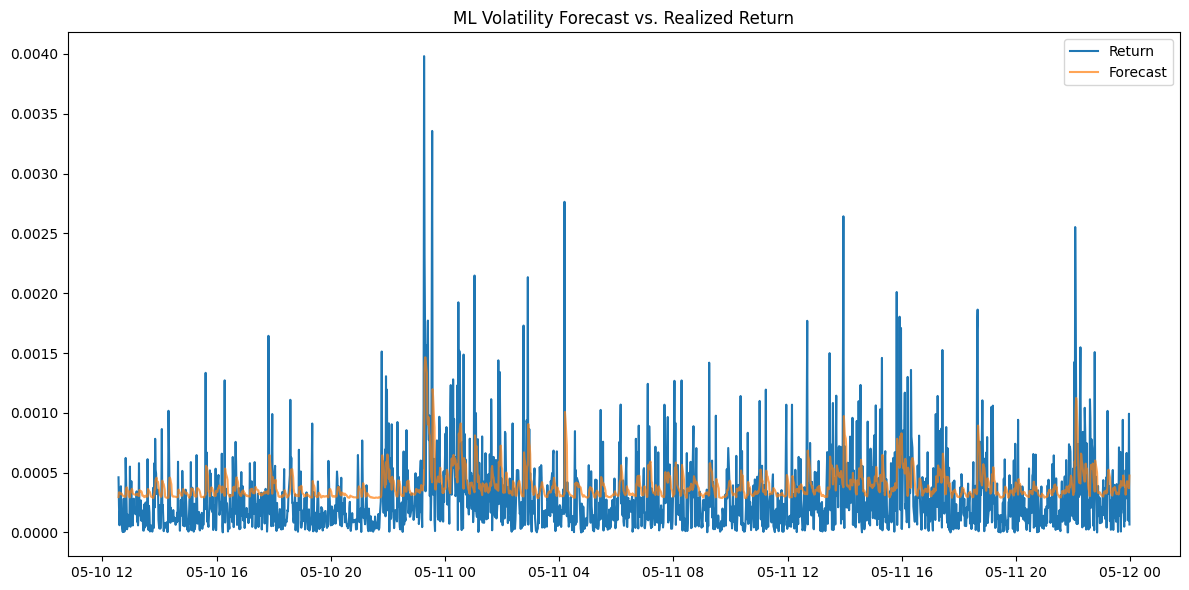

Expected Shortfall at 1%: -0.002002


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

test_idx      = returns.index[-len(pred):]
test_returns  = returns.loc[test_idx]

sigma2_ml     = pd.Series(pred,   index=test_idx, name='sigma2_ml')
sigma2_real   = pd.Series(actual, index=test_idx, name='sigma2_real')


vol_forecast  = np.sqrt(sigma2_ml)          
realized_abs  = test_returns.abs()          

plt.figure(figsize=(12,6))
plt.plot(test_idx, realized_abs, label='Return',    alpha=1)
plt.plot(test_idx, vol_forecast,  label='Forecast', alpha=0.7)
plt.title('ML Volatility Forecast vs. Realized Return')
plt.legend();  plt.tight_layout();  plt.show()

import numpy as np

def expected_shortfall(returns, alpha):
    threshold = np.quantile(returns, alpha)
    return returns[returns <= threshold].mean()

alpha = 0.01
es_5 = expected_shortfall(returns.values, alpha)
print(f"Expected Shortfall at {int(alpha*100)}%: {es_5:.6f}")

